<a href="https://colab.research.google.com/github/anjunjin/PFE-ING3-IA/blob/branch1/AnalyseTweets_ScatterText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Préparations

Préparations pour le reste du programme (importation, récupération du tableau avec les tweets, ...)

Importation des libraries nécessaires

In [1]:
!pip install --upgrade pandas

In [2]:
import pandas as pd
# import pickle

Liaison au Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/PFE/"

Mounted at /content/drive


 La base de données compte 926.188 tweets et les variables suivantes :

*    user_id : l'identifiant twitter du compte
*     user_screen_name : le nom twitter du compte
*    id_tweet : l'identifiant twitter du tweet
*    created_at : la date à laquelle a été publié le tweet
*     tweet : le tweet
*    retweet_count : le nombre de fois à laquelle le tweet a été retweeté
*     favorite_count : le nombre de fois à laquelle le tweet a été mis en favori
*    liability : la fiabilité du compte twitter (donné par les données decodex)
*    liability_label : le label de la fiabilité du compte twitter
*    description : la description du compte twitter (donné par les données decodex)
*    count_followers : le nombre de followers total du compte twitter

Les données pour analyser : liability, retweet_count, favorite_count, count_followers -> pourcentage de "partage" selon nb followers -> tableau de pourcentage selon fiabilité

Réutiliser tweets pour trouver patterns pour analyser nouveaux tweets (scattertext ?)

Code pour obtenir les données du txt.

In [4]:
import pickle

with open(DATA_PATH+"data_tweets.txt", "rb") as file :  
    data_tweets = pickle.load(file)

data_tweets.head(5)

,user_id,user_screen_name,id_tweet,created_at,tweet,retweet_count,favorite_count,liability,description,liability_label,count_followers
0,78957336,france_soir,1466789582213681162,2021-12-03 15:21:02+00:00,🚨Le professeur Raoult écope d’un blâme de l’Or...,50,101,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322
1,78957336,france_soir,1466768535921831946,2021-12-03 13:57:24+00:00,RT @DIVIZIO1: Recours déposé !,643,0,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322
2,78957336,france_soir,1466757902773932035,2021-12-03 13:15:09+00:00,"🎙BEST OF - Pr Michel Drancourt : IHU, épidémie...",27,59,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322
3,78957336,france_soir,1466739848509890566,2021-12-03 12:03:25+00:00,"📚 Jonathan Curiel, directeur général adjoint d...",14,37,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322
4,78957336,france_soir,1466731706912751619,2021-12-03 11:31:04+00:00,🖍 Le dessin du jour\n&gt; à retrouver sur http...,39,79,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322


In [5]:
data_tweets.shape

(926188, 11)

Regroupe par fiabilité pour compter nb user selon la fiabilité

In [6]:
data_tweets.groupby("liability_label").user_screen_name.nunique()

liability_label
site parodique                                              31
site qui diffuse régulièrement de la fausse information     52
site réputé fiable                                         201
site à la fiabilité douteuse                                39
Name: user_screen_name, dtype: int64

In [7]:
data_tweets.groupby("liability_label").id_tweet.nunique()

liability_label
site parodique                                              51506
site qui diffuse régulièrement de la fausse information    133675
site réputé fiable                                         632999
site à la fiabilité douteuse                               108008
Name: id_tweet, dtype: int64

In [8]:
data_tweets.id_tweet.describe()

count                  926188
unique                 926188
top       1466789582213681162
freq                        1
Name: id_tweet, dtype: object

#Scattertext

Blocs pour le scattertext, affichage HTML de l'apparitions des mots selon le groupe de liability.

Objectif actuel : utiliser le corpus créé pour sortir les mots les plus fréquents des 2 groupes (On ne peut pas utiliser l'affichage HTML, on doit obtenir les informations à partir du corpus)

In [9]:
!pip install scattertext

     |████████████████████████████████| 7.3 MB 23.9 MB/s 
     |████████████████████████████████| 24.1 MB 37.3 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9310 sha256=7c581d1793d26f013433e4c2838d02f2fae37bb6b1307444ef49c01d431a6cb8
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [112]:
import scattertext as st
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.fr import French
import numpy as np
import random

On récupère les morceaux du tableau data_tweets qui nous intéresse

In [113]:
# Création des 2 groupes à comparer
group2 = [2] #Groupe des non fiables
df_group2 = data_tweets[data_tweets['liability'].isin(group2)]
group3 = [3] #Groupe peut-être fiable
df_group3 = data_tweets[data_tweets['liability'].isin(group3)]
group4 = [4] #Groupe des fiables
df_group4 = data_tweets[data_tweets['liability'].isin(group4)]

On récupère seulement 6000 tweets (pas besoin de plus), 3000 tweets fiables, 1500 non fiables et 1500 douteux

In [114]:
np.random

#3000 tweets non fiables sélectionnés aléatoirement
remove_n = df_group2.shape[0]-3000
drop_indices = np.random.choice(df_group2.index, remove_n, replace=False)
df_group0 = df_group2.drop(drop_indices)
#3000 tweets peut-être fiables sélectionnés aléatoirement
remove_n = df_group3.shape[0]-3000
drop_indices = np.random.choice(df_group3.index, remove_n, replace=False)
df_group1 = df_group3.drop(drop_indices)
#1500 tweets non fiables sélectionnés aléatoirement
remove_n = df_group2.shape[0]-1500
drop_indices = np.random.choice(df_group2.index, remove_n, replace=False)
df_group2 = df_group2.drop(drop_indices)
#1500 tweets peut-être fiables sélectionnés aléatoirement
remove_n = df_group3.shape[0]-1500
drop_indices = np.random.choice(df_group3.index, remove_n, replace=False)
df_group3 = df_group3.drop(drop_indices)
#3000 tweets fiables sélectionnés aléatoirement
remove_n = df_group4.shape[0]-3000
drop_indices = np.random.choice(df_group4.index, remove_n, replace=False)
df_group4 = df_group4.drop(drop_indices)

In [115]:
spacy.cli.download('fr_core_news_md')

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [116]:
nlp = spacy.load("fr_core_news_md")

On tokénise les tweets

In [128]:
# parse speech text using spaCy
df_group0['parsed'] = df_group0.tweet.apply(nlp)
df_group1['parsed'] = df_group1.tweet.apply(nlp)
df_group2['parsed'] = df_group2.tweet.apply(nlp)
df_group3['parsed'] = df_group3.tweet.apply(nlp)
df_group4['parsed'] = df_group4.tweet.apply(nlp)

On fait en sorte qu'on puisse séparer le tableau final en 2

In [129]:
df_group0['liability'] = 1
df_group1['liability'] = 1
df_group2['liability'] = 1
df_group3['liability'] = df_group2['liability'].iloc[0]
df_group4['liability'] = 0
df_group0['liability_label'] = 'site de fausse information'
df_group2['liability_label'] = 'site réputé douteux'
df_group3['liability_label'] = df_group2['liability_label'].iloc[0]

On forme le tableau final (on peut choisir quels tweets confronter)

In [164]:
df_group = pd.concat([df_group0, df_group4]) #fausse informations vs fiable
# df_group = pd.concat([df_group1, df_group4]) #fiabilité douteuse vs fiable
# df_group = pd.concat([df_group2, df_group3, df_group4]) #faux+doute vs fiable

df_group = df_group.drop(columns=['user_id',
                                  'id_tweet',
                                  'created_at',
                                  'retweet_count',
                                  'favorite_count',
                                  'description',
                                  'count_followers'
                                  ]
                         ).reset_index(drop=True)

df_group = df_group[['liability', 
                     'liability_label', 
                     'tweet', 
                     'user_screen_name', 
                     'parsed'
                     ]]

On forme le corpus à partir de df_group

In [166]:
# convert dataframe into Scattertext corpus
corpus_group = st.CorpusFromParsedDocuments(df_group, category_col='liability_label', parsed_col='parsed').build()

Affichage HTML du corpus

In [135]:
import IPython

# visualize term associations
html = st.produce_scattertext_explorer(corpus_group,
                                    category='site réputé fiable',
                                    category_name='site réputé fiable',
                                    not_category_name='site réputé douteux',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5
                                    )
file_name = 'terms_pair1.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IPython.display.HTML(filename=file_name)

Création d'un tableau contenant les mots les plus fréquent pour chaque site.

Création d'une liste contenant les X premiers mots considérés comme fiables.

Création d'une liste contenant les X premiers mots considérés comme douteux.

In [174]:
name = corpus_group.get_term_freq_df()

apparitions = pd.concat([corpus_group.get_term_freq_df().sort_values(name.columns[1], ascending=False).drop(columns=name.columns[0]).reset_index().rename(columns={name.columns[1]: "nb utilisation fiable", "term": "mots fiables"}),
                         corpus_group.get_term_freq_df().sort_values(name.columns[0], ascending=False).drop(columns=name.columns[1]).reset_index().rename(columns={name.columns[0] : "nb utilisation douteux", "term": "mots douteux"})],
                         axis=1
                         )
# apparitions.head(10)
liste_fiables = [x for x in apparitions['mots fiables'].head(10)]
liste_douteux = [x for x in apparitions['mots douteux'].head(10)]
print(liste_fiables)
print(liste_douteux)

['de', '…', 'la', 'le', '#', 'les', 'à', 'un', 'et', 'en']
['de', '#', '…', 'la', 'le', 'les', 'à', 'et', 'des', 'en']


In [177]:
list(set(liste_fiables).intersection(['test', 'ici', 'pour', 'compter', 'le', 'nombre', 'de', 'mots', 'dans', 'nouveau', 'tweet', 'qui', 'indiquent', 'si', 'fiable', 'ou', 'non']))

['le', 'de']

#Affichage Boxplot pour analyser visuellement

In [29]:
import seaborn as sns

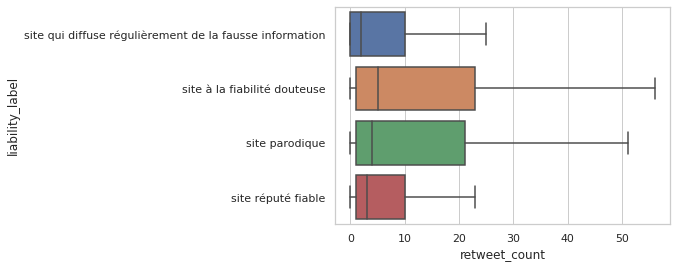

In [30]:
# boxplot
sns.set_theme(style="whitegrid")

ax = sns.boxplot(data=data_tweets, x="retweet_count", y="liability_label", showfliers=False)

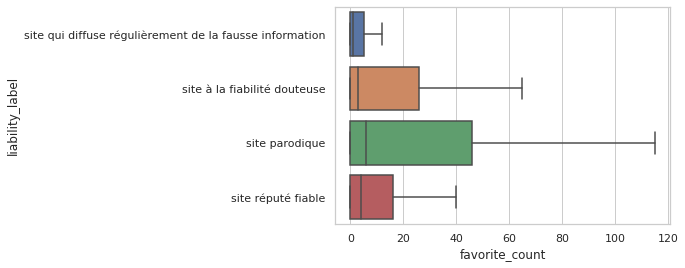

In [31]:
# boxplot
sns.set_theme(style="whitegrid")

ax = sns.boxplot(data=data_tweets, x="favorite_count", y="liability_label", showfliers=False)

On crée un autre tableau avec seulement compte, fiabilité, followers, pour comparer les nb de followers

In [32]:
df_comptes = data_tweets.copy()
df_comptes = df_comptes[["user_screen_name", "liability_label","count_followers"]]
df_comptes = df_comptes.drop_duplicates()
len(df_comptes)

323

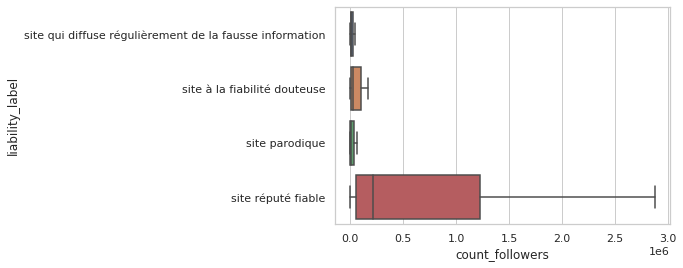

In [33]:
sns.set_theme(style="whitegrid")

aax = sns.boxplot(data=df_comptes, x="count_followers", y="liability_label", showfliers=False)

Ajout de colonnes pour les pourcentage de RT et Like selon le nb de followers de l'user

In [34]:
list_percent_rt = []
list_percent_fav = []
for index, row in data_tweets.iterrows():
  list_percent_rt.append(row['retweet_count']/row['count_followers'])
  list_percent_fav.append(row['favorite_count']/row['count_followers'])
data_tweets['rt_per_followers'] = list_percent_rt
data_tweets['fav_per_followers'] = list_percent_fav
data_tweets.head(10)

,user_id,user_screen_name,id_tweet,created_at,tweet,retweet_count,favorite_count,liability,description,liability_label,count_followers,rt_per_followers,fav_per_followers
0,78957336,france_soir,1466789582213681162,2021-12-03 15:21:02+00:00,🚨Le professeur Raoult écope d’un blâme de l’Or...,50,101,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000509,0.001027
1,78957336,france_soir,1466768535921831946,2021-12-03 13:57:24+00:00,RT @DIVIZIO1: Recours déposé !,643,0,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.006540,0.000000
2,78957336,france_soir,1466757902773932035,2021-12-03 13:15:09+00:00,"🎙BEST OF - Pr Michel Drancourt : IHU, épidémie...",27,59,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000275,0.000600
3,78957336,france_soir,1466739848509890566,2021-12-03 12:03:25+00:00,"📚 Jonathan Curiel, directeur général adjoint d...",14,37,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000142,0.000376
4,78957336,france_soir,1466731706912751619,2021-12-03 11:31:04+00:00,🖍 Le dessin du jour\n&gt; à retrouver sur http...,39,79,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000397,0.000803
5,78957336,france_soir,1466716910129664000,2021-12-03 10:32:16+00:00,🐖L214 a annoncé avoir déposé une plainte pour ...,52,113,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000529,0.001149
6,78957336,france_soir,1466510886386950144,2021-12-02 20:53:36+00:00,"Au soutien de ce dossier mais aussi au-delà, i...",55,161,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000559,0.001637
7,78957336,france_soir,1466510884788973569,2021-12-02 20:53:36+00:00,🎥 Me Heringuez a défendu un couple de restaura...,241,496,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.002451,0.005045
8,78957336,france_soir,1466475302574567427,2021-12-02 18:32:12+00:00,L’entretien complet : https://t.co/0EDJwyvqsM,43,100,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.000437,0.001017
9,78957336,france_soir,1466469320666533900,2021-12-02 18:08:26+00:00,"BEST OF - 🎙️ En Guadeloupe, Me Ellen Bessis et...",377,552,2,France-Soir était un journal fondé par Pierre ...,site qui diffuse régulièrement de la fausse in...,98322,0.003834,0.005614


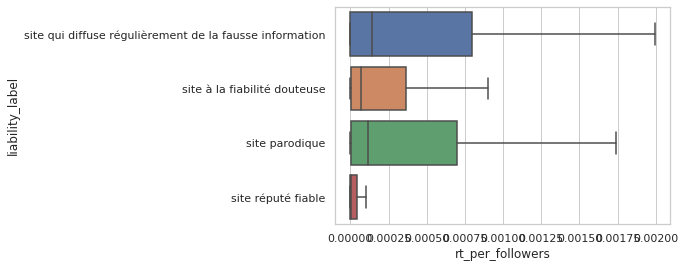

In [35]:
sns.set_theme(style="whitegrid")

ax = sns.boxplot(data=data_tweets, x="rt_per_followers", y="liability_label", showfliers=False)

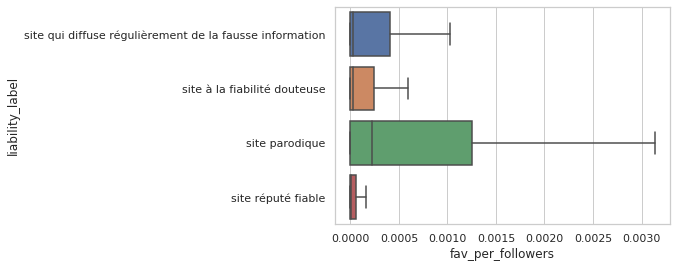

In [36]:
sns.set_theme(style="whitegrid")

ax = sns.boxplot(data=data_tweets, x="fav_per_followers", y="liability_label", showfliers=False)

Utiliser les boxplot pour "catégoriser" et essayer de trouver si on peut déjà séparer certains sites

On va retirer les sites parodiques, peut-être regroupper les non fiable et les douteux 

Avec scatterText, récupère 3000 tweets aléatoirement des 2 catégories restantes et, comme schéma, obtenir un graphique HTML qui trouve les mots propre à chaque catégorie.

Besoin de nettoyer les tweets + retirer les liens + les hashtags + les @s

tokeniser/lemmatiser/autres

#Plein de petites choses (affichage des tweets populaires, nettoyage des tweets, remplacement de termes, ...) 

Fonction de Manon, description dedans

In [37]:
 def print_famous_tweets(df, liability, nb_favorites) :

    ''' Cette fonction permet de sélectionner les tweets qui ont eu le plus de favoris
    pour un user_id donné, et de lire le tweet avec les indicateurs des autres variables de la
    base de données  
    '''

    df_sub = df.loc[(df.liability==liability) & (df.favorite_count > nb_favorites),:]
    for irow in range(df_sub.shape[0]):
        df_row = df_sub.iloc[irow,:]
   
        print(df_row["created_at"])
        print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
        print(df_row["tweet"])
        print("\n")


In [38]:
print_famous_tweets(data_tweets, 4, 50000)

2021-11-06 00:00:03+00:00
favorite_count= 57346 retweet_count=  6140
Marília Mendonça, one of the most popular Brazilian pop singers who was iconic in a type of country music called se… https://t.co/aFYdxp51nZ


2021-01-30 08:18:33+00:00
favorite_count= 50594 retweet_count= 22597
"Un étudiant ne doit pas mourir de faim, se poser des questions sur son loyer. Il doit faire ses études et aller au… https://t.co/VWYlYwbl97


2021-11-30 18:00:05+00:00
favorite_count= 58054 retweet_count= 12145
.@ENHYPEN takes on the ultimate friendship test! These guys have proven that determination, a shared goal, and ligh… https://t.co/RZxyLsH5Cm


2021-11-22 03:59:37+00:00
favorite_count= 65396 retweet_count= 20982
THIS SET IS EVERYTHING #BTS #BTSxAMAs #AMAs https://t.co/igJHUwN6RR


2021-11-22 03:31:24+00:00
favorite_count= 80005 retweet_count= 22082
BTS: *wins artist of the year"
Jin and Jungkook:
#BTS #BTSxAMAs https://t.co/0UR6X36LFv


2021-11-29 15:03:00+00:00
favorite_count= 89752 retweet_count= 216

Vérifier si longueur des tweets permet de catégoriser selon niveau de fiabilité (exemple : les sites fiables font toujours des tweets de plus de 3 "mots")

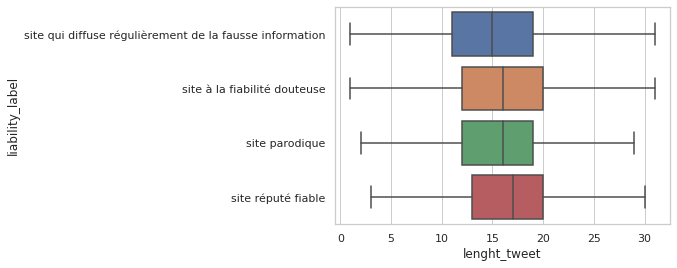

In [39]:
# Calcul d'une variable contenant le nombre de mots de chaque tweets
data_tweets["lenght_tweet"] = data_tweets["tweet"].apply(lambda tweet : len(tweet.split()))

# Calcul de la distribution de la variable pour chaque label
# data_tweets.groupby(["liability_label"]).lenght_tweet.describe()
ax = sns.boxplot(data=data_tweets, x="lenght_tweet", y="liability_label", showfliers=False)

Test de split (sans paramètre, par défault c'est sur l'espace !)

In [40]:
"K. ✍🏻 il.bara | IG https://t.co/qbuaNAPOeD".split()

['K.', '✍🏻', 'il.bara', '|', 'IG', 'https://t.co/qbuaNAPOeD']

Vérifier les tweets de 1 "mot"

In [41]:
data_tweets.loc[data_tweets['lenght_tweet'] == 1, 'tweet']

231       https://t.co/PKeup2vcSq
440       https://t.co/xjlrZptbwS
536                      *Touboul
557       https://t.co/vd57IwKBoC
570       https://t.co/0KyetG1k8u
                   ...           
924809    https://t.co/vrgkb6EHbc
924810    https://t.co/EAIIixZGiw
924811    https://t.co/gw5yUzKsN9
925733    https://t.co/39y0pm1OlZ
926161    https://t.co/VIZXHFZYaV
Name: tweet, Length: 5412, dtype: object

Test pour re.sub

In [42]:
import re

patterns = ['@[a-zA-Z\u00C0-\u00FF0-9]+', '#[a-zA-Z\u00C0-\u00FF0-9]+', '|', 'https://t.co/[a-zA-Z\u00C0-\u00FF0-9]+']

text = "BTS: *wins artist of the year* Jin and Jungkook: #BTS #BTSxAMAs https://t.co/0UR6X36LFv"

for pattern in patterns:
  text = re.sub(pattern,'', text)
  print(text)

# data_tweets['tweet'] = [re.sub(r'','', str(x)) for x in data_df['transcript']]
# text

BTS: *wins artist of the year* Jin and Jungkook: #BTS #BTSxAMAs https://t.co/0UR6X36LFv
BTS: *wins artist of the year* Jin and Jungkook:   https://t.co/0UR6X36LFv
BTS: *wins artist of the year* Jin and Jungkook:   https://t.co/0UR6X36LFv
BTS: *wins artist of the year* Jin and Jungkook:   


Fonctions pour retirer/remplacer du texte dans les tweets afin de les rendre plus facile à "analyser"

remplacement par 'désindentification_'+nom du truc

In [43]:
import re
import string

def remove_spaces(tweet):
  tweet = re.sub('\s{2,}', ' ', tweet)
  return tweet

def replace_stuff(tweet):
  tweet = re.sub('\?', 'point_interrogation', tweet)
  tweet = re.sub('https://t.co/[a-zA-Z\u00C0-\u00FF0-9]+', 'lien_twitter', tweet)
  return tweet

def remove_punctuation(tweet):
  result = "".join([ch for ch in tweet if ch not in string.punctuation.replace('_','')])
  return result

def remove_pattern(tweet):
  patterns = ['\n', '|', '@[a-zA-Z\u00C0-\u00FF0-9]+', '#[a-zA-Z\u00C0-\u00FF0-9]+']
  for pattern in patterns:
    tweet = re.sub(pattern, '', tweet)
  return tweet

def simplification(tweet):
  tweet = replace_stuff(tweet)
  tweet = remove_pattern(tweet)
  tweet = remove_punctuation(tweet)
  tweet = remove_spaces(tweet)
  return tweet

In [44]:
data_tweets["tweet_nettoyé"] = data_tweets["tweet"]

# data_tweets["tweet_nettoyé"] = data_tweets["tweet"].apply(lambda tweet : replace_stuff(tweet)).apply(lambda tweet : remove_pattern(tweet)).apply(lambda tweet : remove_punctuation(tweet)).apply(lambda tweet : remove_spaces(tweet))
data_tweets["tweet_nettoyé"] = data_tweets["tweet"].apply(lambda tweet : simplification(tweet))

In [45]:
# pd.set_option("max_colwidth", 5000)
# data_tweets["tweet"].head()

for tweet in data_tweets["tweet_nettoyé"].head(15):
  print(tweet)

🚨Le professeur Raoult écope d’un blâme de l’Ordre des médecins Article à paraître sur lien_twitter
RT Recours déposé 
🎙BEST OF Pr Michel Drancourt IHU épidémies dhier et daujourdhuiComment la paléomicrobiologie permet dac… lien_twitter
📚 Jonathan Curiel directeur général adjoint des programmes des chaînes M6 W9 et 6ter a publié en octobre 2021 so… lien_twitter
🖍 Le dessin du jourgt à retrouver sur lien_twitter lien_twitter
🐖L214 a annoncé avoir déposé une plainte pour mauvais traitements envers les animaux et tromperie des consommateur… lien_twitter
Au soutien de ce dossier mais aussi audelà il porte une plainte contre X pour RéInfoLiberté et qui… lien_twitter
🎥 Me Heringuez a défendu un couple de restaurateurs qui avait été en garde à vue en février dernier pour avoir reçu… lien_twitter
L’entretien complet lien_twitter
BEST OF 🎙️ En Guadeloupe Me Ellen Bessis et Soumïâa Sayah expliquent les manipulations de la direction des hôpit… lien_twitter
🖍️ Le dessin du jour par lien_twitter
🛂 L

Petit test si je peux éviter de retirer certaines ponctuations

In [46]:
string.punctuation.replace('_','')

'!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'

Il est possible que ce ne soit pas Google Colab/Python/N'importe quel entité qui tronqué les tweets trop long mais en réalité tweepy qui nous a envoyé le tweet tronqué, ou quelquechose comme ça ?